In [1]:
#!pip install geoplot
#!pip install contextily
#!pip install altair

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import geopandas as gpd 
import nltk
nltk.download('punkt')
#import contextily as ctx
#import geoplot as gplt
#import geoplot.crs as gcrs
#import folium
#import seaborn as sns
#import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:
df = pd.read_csv("fr_crous_logement_france_entiere.csv", sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [5]:
from functions_for_modelling import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/onyxia/work/Immobilier-etudiant-/functions_for_modelling.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Surface'][j] = remove(df['Surface'][j], 7, 100)


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965)
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830)
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069)
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880)
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321)
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651)
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899)
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [6]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [7]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [8]:
df_private.rename(columns = {'INSEE':'codgeo'}, inplace = True)

In [9]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
for i in range(0,df_private.shape[0]):
    if  len(df_private["codgeo"][i]) == 4: 
            df_private["codgeo"][i] = "0" +  df_private["codgeo"][i]

In [10]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [11]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


On ne garde que le code INSEE et les données polygoniales. 

In [12]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [13]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [14]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_50210/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [15]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264"
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054"
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618"
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506"
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711"
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502"
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054"
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283"


## 1.4 Ajout des départements 

In [16]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [17]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_50210/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [18]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,index_right,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",73,Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",67,Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",35,Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",8,Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",8,Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",69,Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",98,Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",86,Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",78,Côte-d'Or


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or


## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Calcul d'un cercle de 20 km autour de la résidence
"""
df1 = df
df1 = df1.to_crs(epsg = 3395) #On prend une projection en mètres
df1['geometry'] = df1['geometry'].buffer(20000) #On prend un rayon de 20km 
df1 = df1.to_crs(4326) #on repasse dans la projection uselle 
df1

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],NaN,NaN,NaN,2.044151,48.779652,"POLYGON ((2.22381 48.77965, 2.22295 48.76801, ...",Guyancourt,"21,73842264",Yvelines
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],NaN,NaN,NaN,2.026887,49.048298,"POLYGON ((2.20655 49.04830, 2.20568 49.03672, ...",Cergy,"20,65371054",Val-d'Oise
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],28.0,28.0,28.000000,2.316971,48.790691,"POLYGON ((2.49663 48.79069, 2.49577 48.77905, ...",Bagneux,"24,98281618",Hauts-de-Seine
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],18.0,18.0,18.000000,2.157896,48.698803,"POLYGON ((2.33756 48.69880, 2.33669 48.68714, ...",Bures-sur-Yvette,"21,2713506",Essonne
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],NaN,NaN,NaN,2.184678,48.701542,"POLYGON ((2.36434 48.70154, 2.36348 48.68988, ...",Orsay,"21,07028697",Essonne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",69.0,9.0,40.000000,-0.339214,49.203205,"POLYGON ((-0.15955 49.20321, -0.16042 49.19166...",Hérouville-Saint-Clair,"13,70540711",Calvados
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",35.3,19.0,27.150000,6.015343,47.236507,"POLYGON ((6.19501 47.23651, 6.19414 47.22451, ...",Besançon,"13,92609502",Doubs
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",51.5,18.0,35.166667,6.853714,47.638988,"POLYGON ((7.03338 47.63899, 7.03251 47.62709, ...",Belfort,"13,04684054",Territoire-de-Belfort
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,NaN,NaN,NaN,5.035332,47.322498,"POLYGON ((5.21500 47.32250, 5.21413 47.31052, ...",Dijon,"14,38634283",Côte-d'Or


In [22]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [24]:
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_code_commune,etablissement_commune
427,Université de Strasbourg,54534,67482,Strasbourg
428,Université Toulouse Capitole,17867,31555,Toulouse
429,École nationale supérieure des sciences de l'i...,234,69266,Villeurbanne
430,Université Paris 1 - Panthéon Sorbonne,40413,75105,Paris 5e
431,Université Jean Moulin - Lyon 3,25559,69387,Lyon 7e
...,...,...,...,...
2283,École nationale supérieure de l'électronique e...,874,95127,Cergy
2284,Université Paris-Est Créteil,39198,94028,Créteil
2285,Aix-Marseille Université,71711,13207,Marseille 7e
2286,École nationale supérieure des arts et techniq...,216,69385,Lyon 5e


In [25]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [26]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes

/tmp/ipykernel_50210/123655656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes


In [27]:
df_schools.set_index('codgeo', inplace = True)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune
codgeo,,,
67482,Université de Strasbourg,54534,Strasbourg
31555,Université Toulouse Capitole,17867,Toulouse
69266,École nationale supérieure des sciences de l'i...,234,Villeurbanne
75105,Université Paris 1 - Panthéon Sorbonne,40413,Paris 5e
69387,Université Jean Moulin - Lyon 3,25559,Lyon 7e
...,...,...,...
95127,École nationale supérieure de l'électronique e...,874,Cergy
94028,Université Paris-Est Créteil,39198,Créteil
13207,Aix-Marseille Université,71711,Marseille 7e


In [28]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune,geometry
codgeo,,,,
06088,Université Côte d'Azur,33537,Nice,"POLYGON ((7.32125 43.72359, 7.32113 43.72360, ..."
10387,Université de technologie de Troyes,3235,Troyes,"POLYGON ((4.05058 48.29937, 4.05137 48.29921, ..."
13001,Sciences Po Aix,1682,Aix-en-Provence,"POLYGON ((5.50459 43.53231, 5.50421 43.53234, ..."
13207,Aix-Marseille Université,71711,Marseille 7e,"MULTIPOLYGON (((5.28590 43.26396, 5.28588 43.2..."
13213,Centrale Marseille,1165,Marseille 13e,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."
...,...,...,...,...
97302,Université de Guyane,3890,Cayenne,"MULTIPOLYGON (((-52.16862 4.88872, -52.16870 4..."
97411,Université de La Réunion,17044,Saint-Denis,"POLYGON ((55.46906 -21.00973, 55.47105 -21.008..."
97607,Centre universitaire de Mayotte,1335,Dembeni,"POLYGON ((45.16908 -12.88110, 45.17800 -12.886..."


In [29]:
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [30]:
"""
essai sur la résidence de Cergy 
"""
a = df_schools.within(df1["geometry"][1])
i = 0 
for element in a : 
    if element == True: 
        print(df_schools['etablissement_lib'][i])
    i = i + 1

CY Cergy Paris Université
École nationale supérieure de l'électronique et de ses applications de Cergy


In [31]:
Schools = [] #on crée une liste pour stocker la liste des écoles 
Nbstudents = [] #on crée une liste pour stocker la liste du nombre d'étudiants
Nbstudents_total  = []
for residence in df1["geometry"]: #on prend pour chaque résidence le cercle de 5 km autour de cette résidence
    S = [] #stocke les écoles pour la résidence
    N = [] #idem pour le nb d'étudiants 
    i = 0 #index 
    a = df_schools.within(residence) #On utilise gpd.within qui regarde pour chaque élèment si sa coordonnée est dans le polygone résidence
    for element in a : #on regarde pour chaque élèment de a si l'école est dans le cercle de 5km autour de la résidence
        if element == True: 
            S.append(df_schools['etablissement_lib'][i]) #on ajoute l'école de l'index i 
            N.append(df_schools['effectif_sans_cpge'][i]) #idem pour le nombre d'étudiants
        i = i + 1
    Schools.append(S) 
    Nbstudents.append(N)
    Nbstudents_total.append(sum(N))
df['Schools'] = Schools
df['Nbstudents'] = Nbstudents
df['Nbstudents_total'] = Nbstudents_total
df
       

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total
0,Résidence Vauban,Description La résidence est située au cœur de...,1 boulevard d’Alembert 78280 Guyancourt,"48.7796516418,2.0441513062",Île-de-France,"[333.0, 537.0]",537.00,333.00,435.000000,[],...,NaN,2.044151,48.779652,POINT (2.04415 48.77965),Guyancourt,"21,73842264",Yvelines,[Université de Versailles Saint-Quentin-en-Yve...,"[14583, 48595]",63178
1,Résidence Le Square de l'Echiquier,DescriptionRésidence universitaire nouvellemen...,9 square de l'échiquier 95800 Cergy-Pontoise,"49.0482978821,2.02688694",Île-de-France,[334.0],334.00,334.00,334.000000,[],...,NaN,2.026887,49.048298,POINT (2.02689 49.04830),Cergy,"20,65371054",Val-d'Oise,"[CY Cergy Paris Université, École nationale su...","[26069, 874]",26943
2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,[28.0],...,28.000000,2.316971,48.790691,POINT (2.31697 48.79069),Bagneux,"24,98281618",Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",275639
3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,[18.0],...,18.000000,2.157896,48.698803,POINT (2.15790 48.69880),Bures-sur-Yvette,"21,2713506",Essonne,[Université Paris-Saclay],[48595],48595
4,Résidence La Pacaterie,Description Résidence universitaire longée par...,Bâtiment 499 - rue de la Pacaterie 91400 Orsay,"48.7015419006,2.1846776009",Île-de-France,[154.0],154.00,154.00,154.000000,[],...,NaN,2.184678,48.701542,POINT (2.18468 48.70154),Orsay,"21,07028697",Essonne,[Université Paris-Saclay],[48595],48595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,"[9.0, 18.0, 30.0, 49.0, 65.0, 69.0]",...,40.000000,-0.339214,49.203205,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,"13,70540711",Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933
784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,"[19.0, 35.3]",...,27.150000,6.015343,47.236507,POINT (6.01534 47.23651),Besançon,"13,92609502",Doubs,"[Université Bourgogne - Franche-Comté, École n...","[2077, 779, 23578]",26434
785,Résidence Jean Paul Sartre,Localisation :\r\n La résidence Sartre est sit...,Rue Gaston Deferre 90000 Belfort,"47.6389884949,6.8537139893",Bourgogne-Franche-Comté,"[280.0, 311.0, 361.0, 405.0, 416.0, 466.0, 586.0]",586.00,280.00,403.571429,"[18.0, 36.0, 51.5]",...,35.166667,6.853714,47.638988,POINT (6.85371 47.63899),Belfort,"13,04684054",Territoire-de-Belfort,[Université de technologie de Belfort-Montbéli...,[2641],2641
786,Maret,NaN,3 rue du Docteur Maret 21000 Dijon,"47.3224983215,5.0353322029",Bourgogne-Franche-Comté,None,NaN,NaN,NaN,None,...,NaN,5.035332,47.322498,POINT (5.03533 47.32250),Dijon,"14,38634283",Côte-d'Or,[Université de Bourgogne],[31341],31341


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [32]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [33]:
df["upr.IPm2"] = df["upr.IPm2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [34]:
df["upr.IPm2"] = df["upr.IPm2"].astype(float)

In [35]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_50210/1064917290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min
departement,,,,,,,,,,,
Vaucluse,393.535714,246.552857,308.777857,30.087143,23.815714,26.951429,4.828818,43.944533,14.315362,6787.000000,11.476546
Aisne,307.750000,261.670000,284.710000,20.700000,20.700000,20.700000,3.302897,49.841917,11.992983,0.000000,12.683688
Pyrénées-Orientales,377.166667,313.833333,346.083333,34.000000,26.200000,30.100000,2.895255,42.685872,12.694461,8569.000000,12.685152
Gard,413.138333,325.600000,365.063611,40.500000,25.250000,31.375000,4.357343,43.832422,13.606911,5459.000000,13.134632
Seine-et-Marne,405.333333,318.333333,360.314815,34.000000,23.555556,28.648148,2.596910,48.702632,19.202476,8821.555556,13.803151
...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN
Tarn,NaN,NaN,NaN,23.750000,21.250000,22.500000,2.168522,43.842574,11.575138,2806.500000,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN


## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [36]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [37]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_max')

/tmp/ipykernel_50210/2332010617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max
departement,,,,,,,,,,,,
Métropole de Lyon,384.258065,291.193548,334.958871,91.00,18.00,48.083333,4.852303,45.756218,18.146949,110640.125000,18.250000,4.496288
Eure,385.400000,265.800000,318.800000,45.00,19.00,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779
Vendée,329.635000,324.185000,326.910000,28.00,20.00,23.750000,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571
Gard,413.138333,325.600000,365.063611,40.50,25.25,31.375000,4.357343,43.832422,13.606911,5459.000000,13.134632,11.927731
Pyrénées-Orientales,377.166667,313.833333,346.083333,34.00,26.20,30.100000,2.895255,42.685872,12.694461,8569.000000,12.685152,11.930502
...,...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN
Tarn,NaN,NaN,NaN,23.75,21.25,22.500000,2.168522,43.842574,11.575138,2806.500000,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN


In [38]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.loc[(df_max['prix_par_m2_min']>1)] 

/tmp/ipykernel_50210/2118196628.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [39]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [40]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean

# Modélisation 

On commence par enlever les NaN du dataframe qui bloquent la regression linéaire

In [41]:
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split

In [42]:
#on commence par retirer les NaN pour que les régressions fonctionnent
df.isnull().sum()
df2 = df
index_with_nan = df2.index[df2.isnull().any(axis=1)]
print(index_with_nan.shape)
df2.drop(index_with_nan,0, inplace=True)
print(df2[['Mean Loyer', 'Mean Surface']].isnull().sum())
df2 = df2.reset_index()
df2

/tmp/ipykernel_50210/1823180586.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop(index_with_nan,0, inplace=True)


(423,)
Mean Loyer      0
Mean Surface    0
dtype: int64


,index,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,...,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean
0,2,Résidence Les Bas Longchamps,Description Résidence universitaire située à p...,2 rue Abraham Lincoln 92220 Bagneux,"48.7906913757,2.3169708252",Île-de-France,"[332.0, 359.0]",359.00,332.00,345.500000,...,POINT (2.31697 48.79069),Bagneux,24.982816,Hauts-de-Seine,"[Université Paris Lumières, Université Paris 1...","[78, 40413, 15404, 1937, 22246, 422, 52969, 59...",275639,11.857143,12.821429,12.339286
1,3,Résidence de l’Ile,Description Résidence universitaire située à p...,14 rue du Docteur Collé - bâtiment 227 du camp...,"48.698802948,2.1578958035",Île-de-France,[362.0],362.00,362.00,362.000000,...,POINT (2.15790 48.69880),Bures-sur-Yvette,21.271351,Essonne,[Université Paris-Saclay],[48595],48595,20.111111,20.111111,20.111111
2,5,Résidence La Fresque,Description Résidence universitaire située aux...,10 rue Edmé Bouchardon 78000 Versailles,"48.8112220764,2.1460649967",Île-de-France,"[424.0, 537.0]",537.00,424.00,480.500000,...,POINT (2.14606 48.81122),Versailles,28.519253,Yvelines,[Université de Versailles Saint-Quentin-en-Yve...,"[14583, 48595, 305]",63483,16.758893,21.225296,18.992095
3,15,Résidence Fernand Braudel,Localisation :\r\n La résidence Fernand Braude...,Rue Ernest Duvillard 90016 Belfort,"47.6403808594,6.8530831337",Bourgogne-Franche-Comté,"[277.0, 321.0, 427.0, 399.0]",427.00,277.00,356.000000,...,POINT (6.85308 47.64038),Belfort,13.046841,Territoire-de-Belfort,[Université de technologie de Belfort-Montbéli...,[2641],2641,14.578947,8.933054,10.595238
4,16,Résidence Portes du Jura,Localisation :\r\n A 5 minutes à pied du resto...,23 rue Maurice Ravel 25200 Montbéliard,"47.4966392517,6.8003001213",Bourgogne-Franche-Comté,[339.0],339.00,339.00,339.000000,...,POINT (6.80030 47.49664),Montbéliard,12.278547,Doubs,[Université de technologie de Belfort-Montbéli...,[2641],2641,18.833333,18.833333,18.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,781,Résidence du Panorama (secteur Rouen),Localisation\r\n Proche de l'université \r\nDe...,Boulevard Siegfried 76130 Mont-Saint-Aignan,"49.4621658325,1.0657054186",Normandie,"[248.0, 288.0, 315.0, 203.0, 344.0, 430.0]",430.00,203.00,304.666667,...,POINT (1.06571 49.46217),Mont-Saint-Aignan,14.845433,Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442,22.555556,8.600000,14.585106
361,782,Résidence Emma Bovary (secteur Rouen),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,4 boulevard Gambetta 76000 ROUEN,"49.4363975525,1.1012332439",Normandie,"[381.1, 417.7]",417.70,381.10,399.400000,...,POINT (1.10123 49.43640),Rouen,14.850004,Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442,21.172222,19.890476,20.482051
362,783,Cité Grémillon (secteur d'Hérouville-Saint-Clair),BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,BP 54 - Avenue de la Grande Cavée 14202 Hérouv...,"49.2032051086,-0.3392136097",Normandie,"[249.85, 312.9, 388.6, 467.4, 525.0, 556.14]",556.14,249.85,416.648333,...,POINT (-0.33921 49.20321),Hérouville-Saint-Clair,13.705407,Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933,27.761111,8.060000,10.416208
363,784,Résidence Antide Janvier,"Localisation :\r\n Au centre ville, à proximit...",6 rue Antide Janvier 25000 Besançon,"47.2365074158,6.0153431892",Bourgogne-Franche-Comté,"[347.0, 502.0, 523.0]",523.00,347.00,457.333333,...,POINT (6.01534 47.23651),Besançon,13.926095,Doubs,"[Université Bourgogne - Franche-Comté, École n...","[2077, 779, 23578]",26434,18.263158,14.815864,16.844690


### Regressions linéaires OLS

#### https://www.statology.org/simple-linear-regression-in-python/

In [43]:
print(df2['Mean Surface'].describe()) #on vérifie qu'il n'y a pas de valeurs incohérentes (min, max) qui viendraient fausser les résultats
print(df2['Mean Loyer'].describe())

count    365.000000
mean      22.712599
std        9.287976
min        9.000000
25%       18.000000
50%       21.000000
75%       26.666667
max       88.000000
Name: Mean Surface, dtype: float64
count    365.000000
mean     366.449480
std       80.829975
min      146.000000
25%      314.770833
50%      362.571429
75%      416.648333
max      659.000000
Name: Mean Loyer, dtype: float64


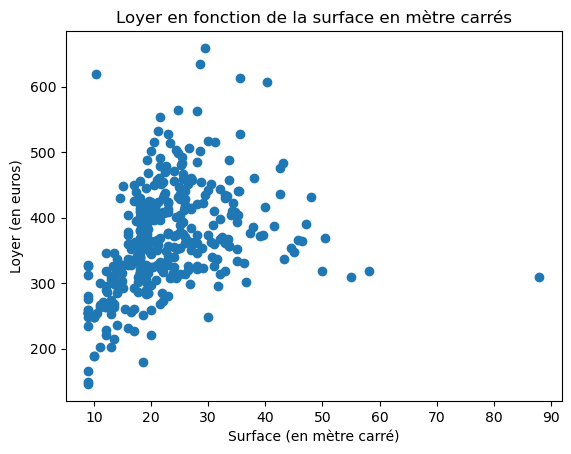

In [44]:
plt.scatter(df2['Mean Surface'], df2['Mean Loyer']) #on regarde la répartition des loyers en fonction de la surface.
plt.title('Loyer en fonction de la surface en mètre carrés')
plt.xlabel('Surface (en mètre carré)')
plt.ylabel('Loyer (en euros)')
plt.show()


In [45]:
#define response variable
y = df2['Mean Loyer']

#define explanatory variable
x = df2['Mean Surface']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Mean Loyer   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     57.17
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           3.30e-13
Time:                        14:33:19   Log-Likelihood:                -2093.9
No. Observations:                 365   AIC:                             4192.
Df Residuals:                     363   BIC:                             4200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          293.5376     10.416     28.182   

In [46]:
#le R² est faible: la variable explicative (ici la surface moyenne) n'est pas très utile pour prédire le résultat. 

eval_env: 1


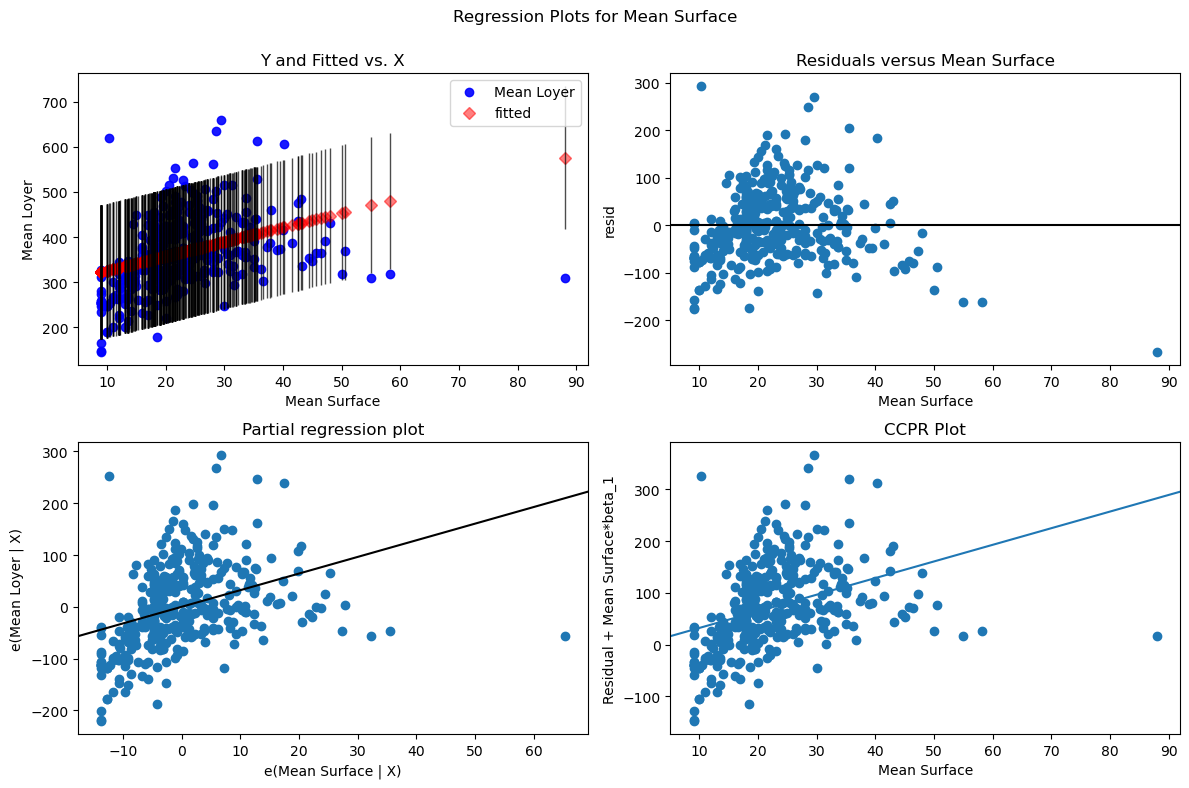

In [47]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce residual plots
fig = sm.graphics.plot_regress_exog(model, 'Mean Surface', fig=fig)

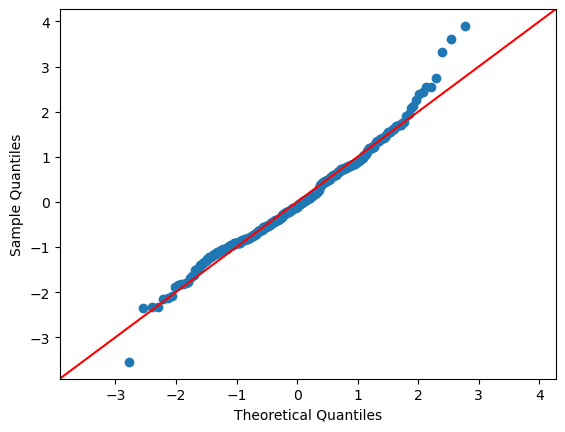

In [48]:
#define residuals
res = model.resid

#create Q-Q plot
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 


### Régression linéaire du prix par m² des résidences Crous ('Mean Loyer'/'Mean Surface') expliqué par le prix au m² des résidences privées

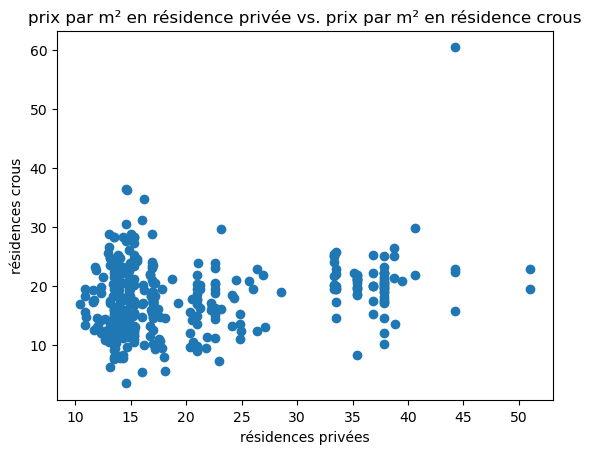

In [49]:
plt.scatter(df2['upr.IPm2'], df2['Mean Loyer']/df2['Mean Surface'])
plt.title('prix par m² en résidence privée vs. prix par m² en résidence crous')
plt.xlabel('résidences privées')
plt.ylabel('résidences crous')
plt.show()

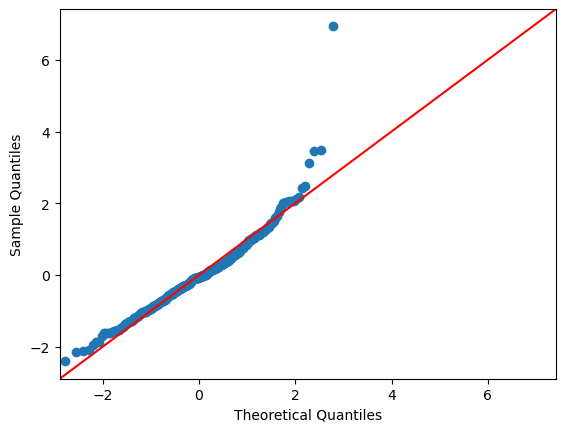

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.062
 Model:                            OLS   Adj. R-squared:                  0.059
 Method:                 Least Squares   F-statistic:                     23.91
 Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.52e-06
 Time:                        15:16:16   Log-Likelihood:                -1145.6
 No. Observations:                 365   AIC:                             2295.
 Df Residuals:                     363   BIC:                             2303.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [96]:
get_simple_OLS_reg(df2['upr.IPm2'],df2['Mean Loyer']/df2['Mean Surface'])

In [50]:
Y = df2['Mean Loyer']/df2['Mean Surface'] #on définit la variable Y, le prix du m² moyen des résidences crous
X = df2[['upr.IPm2']] #la variable explicative est le prix au m² des résidences privées

X = sm.add_constant(X) #on ajoute une constante au vecteur des variables explicatives

#fit linear regression model
model = sm.OLS(Y, X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     23.91
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.52e-06
Time:                        14:33:21   Log-Likelihood:                -1145.6
No. Observations:                 365   AIC:                             2295.
Df Residuals:                     363   BIC:                             2303.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6556      0.721     20.319      0.0

In [51]:
#le R² est très proche de zéro: comme on pouvait s'y attendre, le prix par mètre carré des loyers privés ne permet pas d'expliquer le prix par mètre carré des loyers des résidences du crous

In [52]:
#regardons si les résidus semblent homoscedastiques ou pas

eval_env: 1


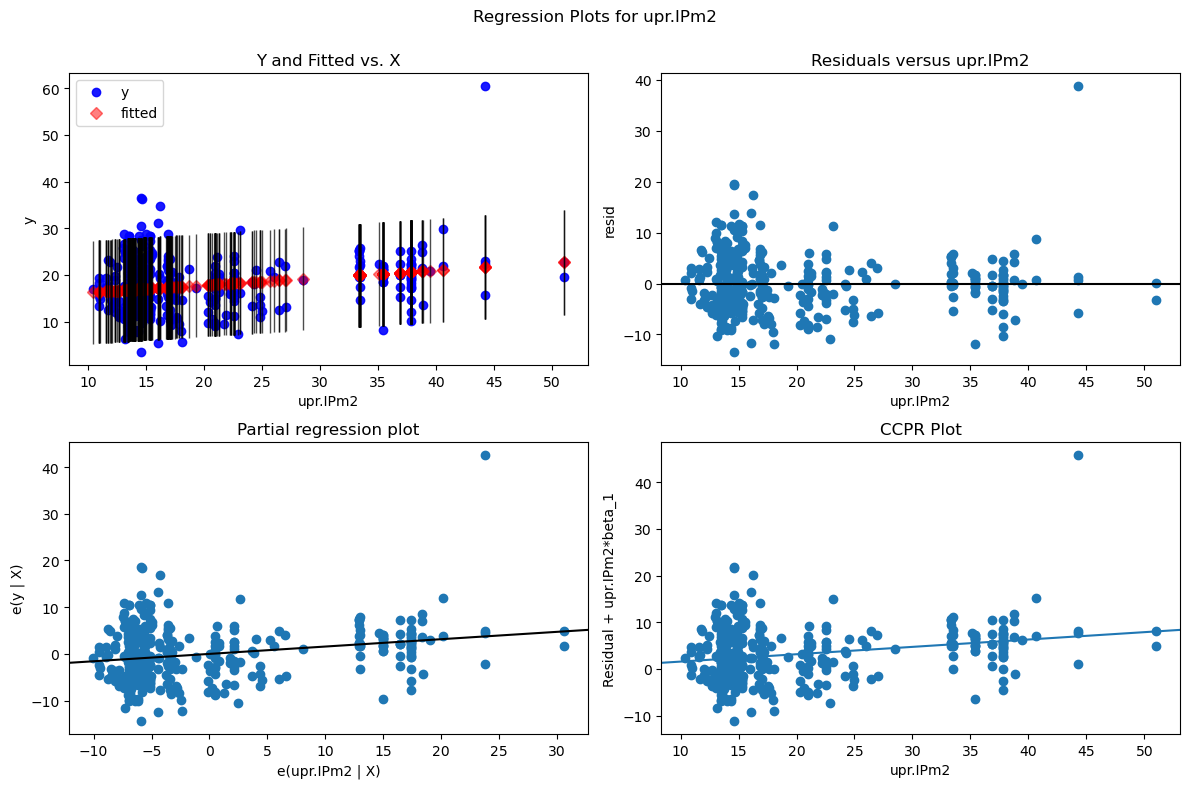

In [53]:
#define figure size
fig = plt.figure(figsize=(12,8))

#produce residual plots
fig = sm.graphics.plot_regress_exog(model, 'upr.IPm2', fig=fig)

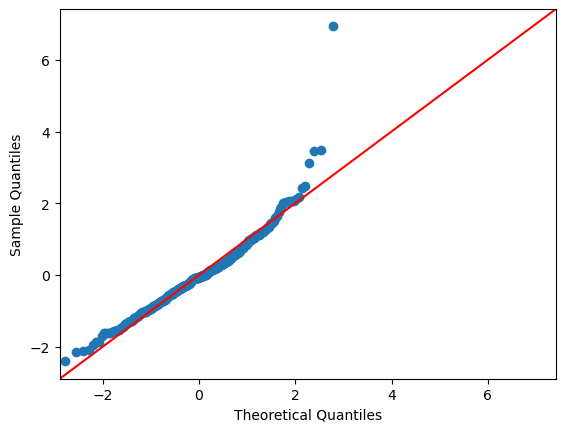

In [54]:
#define residuals
res = model.resid

#create Q-Q plot
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 

### Régression linéaire du loyer en fonction du nombre d'étudiants total

In [55]:
#on crée un nouveau dataframe df_students où on ne garde que les résidences avec plus de 1000 étudiants
i = df2[df2['Nbstudents_total']<=1000].index.values
df_students = df2.drop(i,axis=0) 

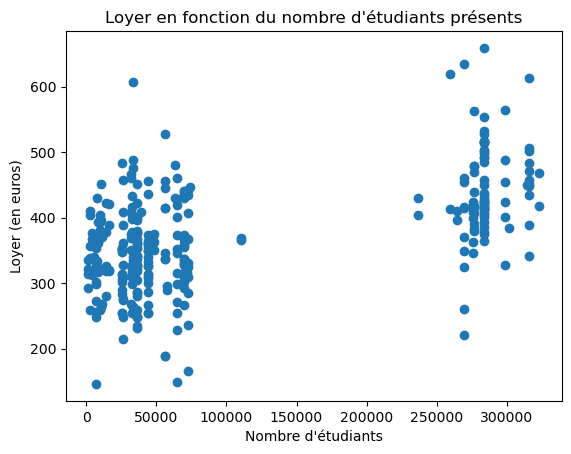

In [56]:
plt.scatter(df_students['Nbstudents_total'], df_students['Mean Loyer']) #on regarde la répartition des loyers en fonction de la surface.
plt.title("Loyer en fonction du nombre d'étudiants présents")
plt.xlabel("Nombre d'étudiants")
plt.ylabel('Loyer (en euros)')
plt.show()

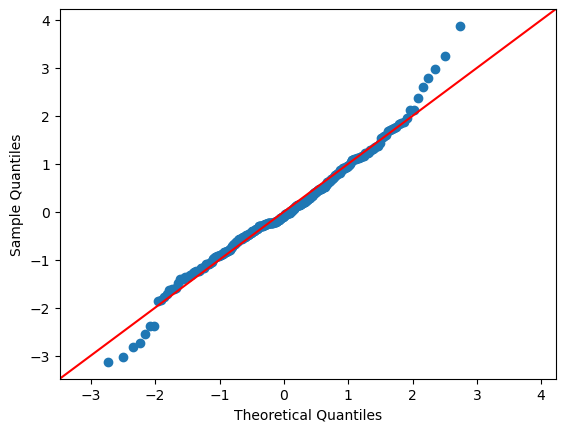

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             Mean Loyer   R-squared:                       0.291
 Model:                            OLS   Adj. R-squared:                  0.289
 Method:                 Least Squares   F-statistic:                     130.8
 Date:                Sun, 11 Dec 2022   Prob (F-statistic):           1.32e-25
 Time:                        15:02:52   Log-Likelihood:                -1804.4
 No. Observations:                 320   AIC:                             3613.
 Df Residuals:                     318   BIC:                             3620.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [90]:
get_simple_OLS_reg(df_students['Nbstudents_total'],df_students['Mean Loyer'])

### Régression longue du prix par mètre carré des résidences Crous ('Mean Loyer'/'Mean Surface') expliqué par le nombre d'étudians total et le prix au mètre carré des résidences privées

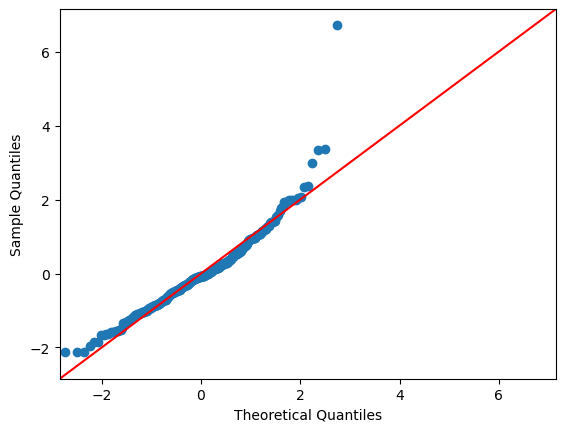

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.060
 Model:                            OLS   Adj. R-squared:                  0.055
 Method:                 Least Squares   F-statistic:                     10.20
 Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.07e-05
 Time:                        15:04:06   Log-Likelihood:                -1011.0
 No. Observations:                 320   AIC:                             2028.
 Df Residuals:                     317   BIC:                             2039.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [91]:
get_simple_OLS_reg(df_students[['Nbstudents_total','upr.IPm2']],df_students['Mean Loyer']/df_students['Mean Surface'])

In [57]:
Y = df_students['Mean Loyer']/df_students['Mean Surface'] #on définit la variable Y, le prix du m² moyen des résidences crous
X = df_students[['Nbstudents_total','upr.IPm2']] #la variable explicative est le prix au m² des résidences privées

X = sm.add_constant(X) #on ajoute une constante au vecteur des variables explicatives

#fit linear regression model
model = sm.OLS(Y, X).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     10.20
Date:                Sun, 11 Dec 2022   Prob (F-statistic):           5.07e-05
Time:                        14:33:23   Log-Likelihood:                -1011.0
No. Observations:                 320   AIC:                             2028.
Df Residuals:                     317   BIC:                             2039.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.3893      1.150  

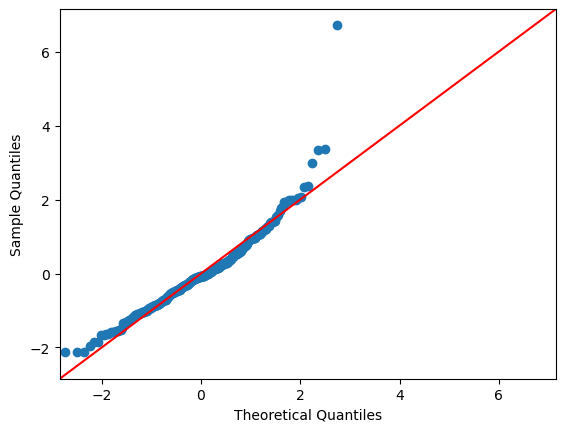

In [58]:
#define residuals
res = model.resid

#create Q-Q plot
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 

In [59]:
#on obtient presque le même graphique que pour la régression simple des prix au mètre carré des résidences crous sur les prix au mètre carré des résidences privées.
#le coefficient associé au nombre d'étudiants total est extrêmement faible.

## Regressions linéaires avec le module LinearRegression de sklearn

### On reprend la première régression effectuée plus haut: le loyer moyen expliqué par la surface moyenne

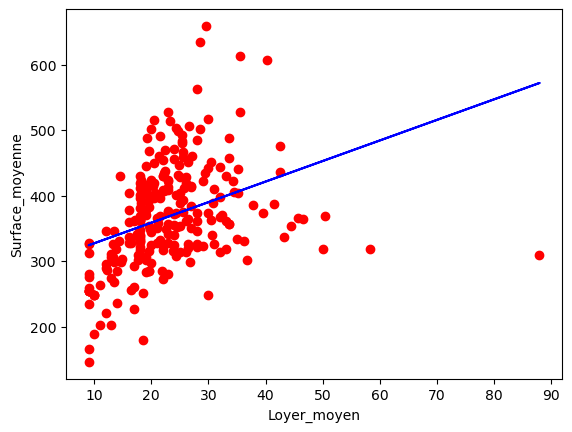

{'r_square=': 0.13312605751887518,
 'coefficients_sans_cst=': 3.1369334585203927}

In [125]:
get_sklearn_regression(df2['Mean Surface'],df2['Mean Loyer'],'Loyer_moyen','Surface_moyenne')

In [60]:
var_explicatives = df2['Mean Surface']
YLoyer = df2['Mean Loyer']
#on transforme Y et X en matrices colonnes
YLoyer = np.array(YLoyer).reshape(-1,1)
var_explicatives = (np.array(var_explicatives).reshape(-1,1))

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(var_explicatives,YLoyer,test_size=0.3,train_size=0.7)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst)

0.13046733306479208
[[3.15096219]]


In [62]:
#On trouve un résultat légèrement différent de celui avec sm.OLS

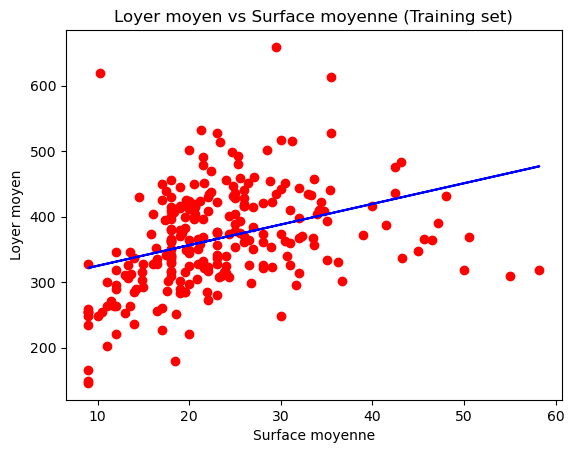

In [63]:

plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Surface moyenne (Training set)") # stating the title of the graph
 
plt.xlabel("Surface moyenne") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph


In [64]:
#Deuxième essai: regression linéaire du min Loyer sur min surface 

In [65]:
df2[['Min Loyer', 'Min Surface']].isnull().sum()

Min Loyer      0
Min Surface    0
dtype: int64

In [66]:
X_min_surface = df2['Min Surface'] #la variable explicative
Y_min_Loyer = df2['Min Loyer']
#on transforme Y et X en array que l'on reformate
Y_min_Loyer = np.array(Y_min_Loyer).reshape(-1,1)
X_min_surface = (np.array(X_min_surface).reshape(-1,1))

In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X_min_surface,Y_min_Loyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.061565580456388824
[[2.75882324]]


In [68]:
#avec la régression du min Loyer sur min Surface, on a un R² peu significatif

#### Regression linéaire du Loyer sur le nombre total d'étudiants

In [69]:
X_Nbstudents = df_students['Nbstudents_total'] #la variable explicative
YLoyer = df_students['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_Nbstudents = (np.array(X_Nbstudents).reshape(-1,1))

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.2620081643852259
[[0.00036928]]


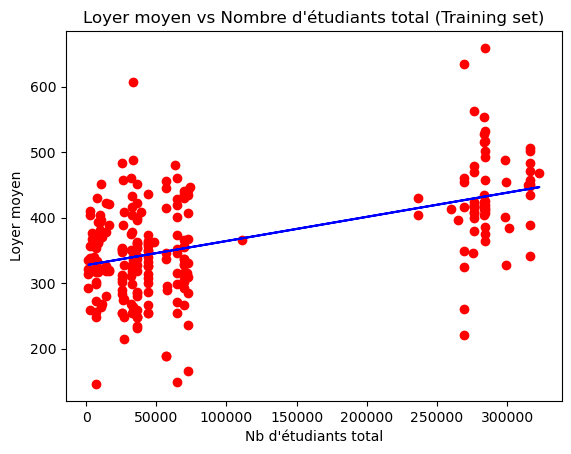

In [71]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen vs Nombre d'étudiants total (Training set)") # stating the title of the graph
 
plt.xlabel("Nb d'étudiants total") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [72]:
#Regression linéaire du Loyer sur le LOG du nombre total d'étudiants

In [73]:
X_log_Nbstudents = np.log(df_students['Nbstudents_total']) #la variable explicative
YLoyer = df_students['Mean Loyer']
#on transforme Y et X en array que l'on reformate
YLoyer = np.array(YLoyer).reshape(-1,1)
X_log_Nbstudents = (np.array(X_log_Nbstudents).reshape(-1,1))

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(X_log_Nbstudents,YLoyer,test_size=0.2,train_size=0.8)
lin= LinearRegression()
reg = lin.fit(X_train,Y_train)
pred_train = lin.predict(X_train)
pred_test = lin.predict(X_test)

coefficients_sans_cst= reg.coef_
r_2 = reg.score(X_train,Y_train)
print(r_2)
print(coefficients_sans_cst) 

0.21971194855497
[[29.38553263]]


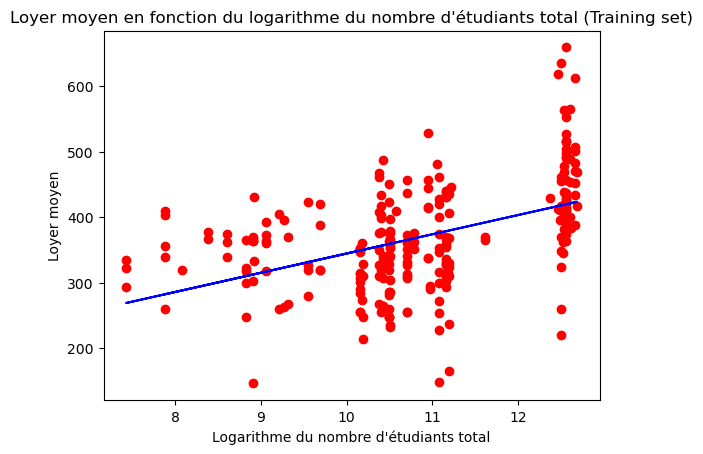

In [75]:
plt.scatter(X_train, Y_train, color='red') # plotting the observation line
 
plt.plot(X_train, lin.predict(X_train), color='blue') # plotting the regression line
 
plt.title("Loyer moyen en fonction du logarithme du nombre d'étudiants total (Training set)") # stating the title of the graph
 
plt.xlabel("Logarithme du nombre d'étudiants total") # adding the name of x-axis
plt.ylabel("Loyer moyen") # adding the name of y-axis
plt.show() # specifies end of graph

In [76]:
#régression linéaire du 